# Setup

In [2]:
# Install necessary packages
# For reading the dataset from Kaggle
!pip install opendatasets

In [3]:
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# For reading the dataset from Kaggle
import opendatasets as od
import pandas

# For reading the image file paths from the "Files" tab
import os

# For getting the actual images from "Files" tab, from a file path
import PIL
from PIL import Image

In [4]:
# Set the random seed
np.random.seed(42)

# Define some variables
labels = (0, 1, 2, 3, 4, 5, 6, 7)
label_strings = ("airplane", "car", "cat", "dog", "flower", "fruit", "motorbike", "person")
label_count = len(labels)
random_state = 42
epoch_amount = 6
batch_size = 32
# image height and width, 3 RGB channels
input_image_shape = (64, 64, 3)

# Data Retrieval (requires Kaggle API token key)

In [6]:
# Load the dataset from Kaggle


# Download Kaggle API token key from the Kaggle website while logged into your account
# Use this key to login when running this code block
dataset_path = "https://www.kaggle.com/datasets/prasunroy/natural-images"
od.download(dataset_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kevinkubota
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images


100%|██████████| 342M/342M [00:03<00:00, 114MB/s]


# Data Setup

In [7]:
# Returns the images and labels of all examples in the dataset
def load_dataset(dataset_directory: str):
  x_temp, y_temp = [], []
  # Traverse through the directory
  for root, directories, files in os.walk(dataset_directory):
    for filename in files:
      # Join the strings to get the file's full path
      filepath = os.path.join(root, filename)
      for label in labels:
        # An example is labeled if its file path contains the label in its name
        if label_strings[label] in filename:
          x_temp.append(Image.open(filepath))
          y_temp.append(label)
  return x_temp, y_temp


natural_dataset_path = "natural-images/data/natural_images"
x_raw, y_raw = load_dataset(natural_dataset_path)
if len(x_raw) != len(y_raw):
  Exception("x train and y train have unequal sizes")
m = len(x_raw)

In [8]:
# Resize all dataset images to be the same size
def resize_images(images, new_size):
  for i in range(len(images)):
    images[i] = images[i].resize(new_size)
  return images

x_resized = resize_images(x_raw, (input_image_shape[0], input_image_shape[1]))

In [9]:
# Split the entire dataset into the appropriate smaller datasets
x_train_all = np.array(x_resized)
y_train_all = np.array(y_raw)

# 60% training, 40% testing
x_train, x_test_all, y_train, y_test_all = train_test_split(x_train_all, y_train_all, test_size = 0.4, random_state = random_state)
# From the 40% testing, it gets split into 20% validation and 20% (actual) testing
x_dev, x_test, y_dev, y_test = train_test_split(x_test_all, y_test_all, test_size = 0.5, random_state = random_state)

In [10]:
# Verify the datasets are reasonably split
print("x train all shape = ", x_train_all.shape)
print("y train all shape = ", y_train_all.shape)
print("x train shape = ", x_train.shape)
print("y train shape = ", y_train.shape)
print("x dev shape = ", x_dev.shape)
print("y dev shape = ", y_dev.shape)
print("x test shape = ", x_test.shape)
print("y test shape = ", y_test.shape)

x train all shape =  (6899, 64, 64, 3)
y train all shape =  (6899,)
x train shape =  (4139, 64, 64, 3)
y train shape =  (4139,)
x dev shape =  (1380, 64, 64, 3)
y dev shape =  (1380,)
x test shape =  (1380, 64, 64, 3)
y test shape =  (1380,)


# Model Training

In [11]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", padding = "same", input_shape = input_image_shape))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", padding = "same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 128, activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units = label_count, activation = "softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                        

In [13]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 3 * 1e-4),
    metrics = ["accuracy"]
    )

In [14]:
history = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epoch_amount,
    validation_data = (x_dev, y_dev)
    )

Epoch 1/6
130/130 [==============================] - 160s 1s/step - loss: 0.5834 - accuracy: 0.8000 - val_loss: 1.1418 - val_accuracy: 0.5551
Epoch 2/6
130/130 [==============================] - 148s 1s/step - loss: 0.1903 - accuracy: 0.9355 - val_loss: 0.3472 - val_accuracy: 0.8862
Epoch 3/6
130/130 [==============================] - 143s 1s/step - loss: 0.0813 - accuracy: 0.9785 - val_loss: 0.2558 - val_accuracy: 0.9007
Epoch 4/6
130/130 [==============================] - 148s 1s/step - loss: 0.0536 - accuracy: 0.9886 - val_loss: 0.2434 - val_accuracy: 0.9116
Epoch 5/6
130/130 [==============================] - 138s 1s/step - loss: 0.0311 - accuracy: 0.9932 - val_loss: 0.2585 - val_accuracy: 0.9109
Epoch 6/6
130/130 [==============================] - 147s 1s/step - loss: 0.0191 - accuracy: 0.9966 - val_loss: 0.2080 - val_accuracy: 0.9254


# Model Graphs

In [18]:
model_iter = np.asarray([i for i in range(epoch_amount)])
model_loss = history.history["loss"]
model_accuracy = history.history["accuracy"]
model_val_loss = history.history["val_loss"]
model_val_accuracy = history.history["val_accuracy"]

plot_titles = ["Train loss", "Train accuracy", "Valid loss", "Valid accuracy"]
model_data = [model_loss, model_accuracy, model_val_loss, model_val_accuracy]
plot_colors = ["red", "green", "red", "green"]
plot_labels = ["Loss", "Accuracy", "Loss", "Accuracy"]

zip_first = zip(plot_titles[:2], model_data[:2], plot_colors[:2], plot_labels[:2])
zip_last = zip(plot_titles[2:], model_data[2:], plot_colors[2:], plot_labels[2:])


def show_graph(zipped_data):
  for plot_title, model_datum, plot_color, plot_label in zipped_data:
    plt.plot(model_iter, model_datum, color = plot_color, marker = 'o', linestyle = "solid")
    plt.title(plot_title)
    plt.ylabel(plot_label)
    for it, datum in zip(model_iter, model_datum):
      formatted = "{:.2f}".format(datum)
      plt.annotate(formatted, xy = (it, datum), xytext = (2, 2), textcoords = "offset points")
    plt.show()

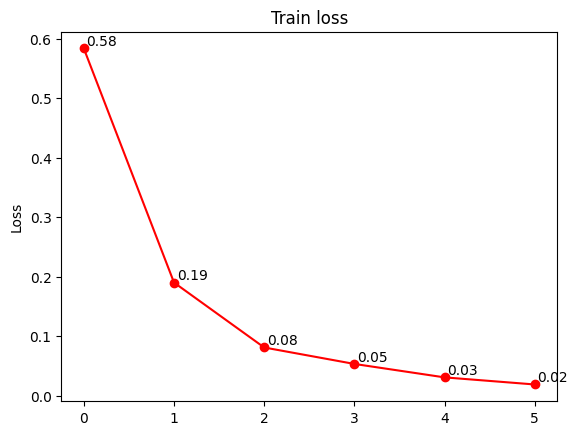

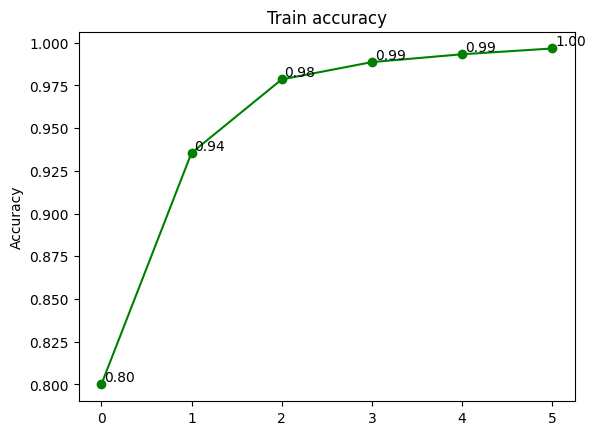

In [19]:
show_graph(zip_first)

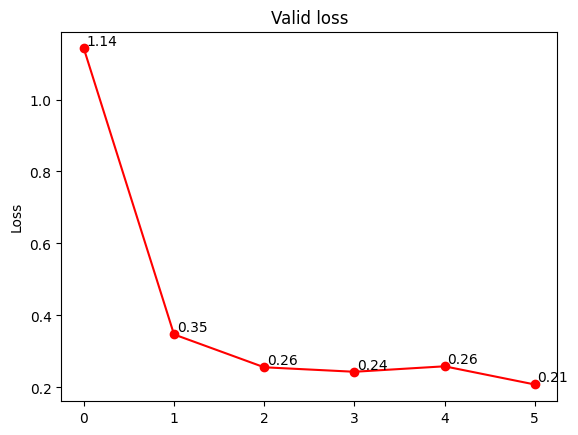

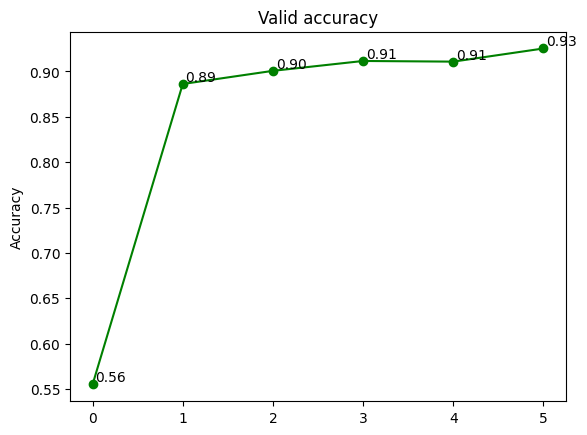

In [20]:
show_graph(zip_last)

# Model Evaluation

In [24]:
y_probabilities = model.predict(
    x = x_test,
    batch_size = batch_size
)

# Converts the arrays of probabilities (for each image being each label) to the actual labels
y_predictions = np.argmax(y_probabilities, axis = 1)

44/44 [==============================] - 12s 262ms/step


In [25]:
y_evaluations = model.evaluate(x = x_test, y = y_test)
print("Total loss =", y_evaluations[0])
print("Total accuracy =", y_evaluations[1])

print("Predictions =", np.array(label_strings)[y_predictions])
print("Actual =", np.array(label_strings)[y_test])

44/44 [==============================] - 10s 221ms/step - loss: 0.2206 - accuracy: 0.9188
Total loss = 0.2206074744462967
Total accuracy = 0.9188405871391296
Predictions = ['person' 'fruit' 'flower' ... 'airplane' 'car' 'fruit']
Actual = ['person' 'fruit' 'flower' ... 'airplane' 'car' 'fruit']


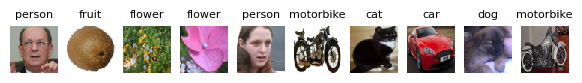

In [26]:
sub_test_amount = 10
x_sub = x_test[:sub_test_amount]
y_sub = y_predictions[:sub_test_amount]

plt.figure(figsize = (7.2, 2.4))
for index, image in enumerate(x_sub):
    plt.subplot(1, sub_test_amount, index + 1)
    plt.imshow(image, cmap = "binary", interpolation = "nearest")
    plt.axis('off')
    plt.title(label_strings[y_sub[index]], fontsize = 8)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.show()